# Polyjuice Potion

You might be asking what is this...

Just a mix and mash of ADC, T2W and so on

TODO: Definire classe 1 e 2 per esempio classe 1: ISUP 2,3 mentre classe 2: ISUP 3,4.

Una classe puo avere 1 o piu valori

# Imports

In [10]:
import numpy as np
import pandas as pd
from typing import Literal
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Data Reader

In [11]:
def is_single_string(param):
    return isinstance(param, str)

def is_list_of_strings(param):
    return isinstance(param, (list, tuple)) and all(isinstance(item, str) for item in param)

In [12]:
def no_polyjuice_getter(sequence, dataset):
    # Filter the dataset to include only AI annotations and selected sequences and ROI lesion
    filtered_dataset = dataset[dataset['annotator'] == 'AI']
    filtered_dataset = filtered_dataset[filtered_dataset['sequence'] == sequence]
    filtered_dataset = filtered_dataset[filtered_dataset['ROI'] == 'lesion']
    filtered_dataset.drop(columns=['annotator', 'sequence', 'ROI_ID', 'ROI','img_path', 'seg_path', 'extraction_ID'], inplace=True)
    dataset = filtered_dataset

    return dataset

In [13]:
def polyjuice_getter(sequence, dataset):
    polyjuice_dataset = None
    filtered_dataset = dataset[dataset['annotator'] == 'AI']
    filtered_dataset = filtered_dataset[filtered_dataset['ROI'] == 'lesion']
    filtered_dataset.drop(columns=['annotator', 'ROI_ID', 'ROI','img_path', 'seg_path', 'extraction_ID'], inplace=True)

    for index, s in enumerate(sequence):
        s_dataset = filtered_dataset[filtered_dataset['sequence'] == s]
        s_dataset = s_dataset.drop(columns=['sequence'])
        for col in s_dataset.columns:
            if col != 'patient_ID' and col != 'study_ID':
                s_dataset = s_dataset.rename(columns={col : str(col + '_' + s)})
        if index == 0:
            polyjuice_dataset = s_dataset
        else:
            polyjuice_dataset = pd.merge(polyjuice_dataset, s_dataset, on=['patient_ID', 'study_ID'], how='inner')

    return polyjuice_dataset

In [14]:
SingleSequence = Literal['t2w', 'adc', 'hbv']


def get_data(sequence : SingleSequence | str | list[str], isup_class1 : list[int] = [0, 1, 2], isup_class2 : list[int] = [3, 4, 5], corr_cutoff=0.9):
    '''
    @param squence : What sequence do you want to study. A list of multiple sequence will also work!
    @param isup_class1 : What ISUP values do you want in the first class
    @param isup_class2 : What ISUP values do you want in the second class
    @param corr_cutoff : The value to cutoff high correlated features

    @return pd.DataFrame : a new columns 'is_class1' is added, specofing if the row is in class1

    Please read the code and the comments, especially the one at the bottom! Some unwanted columns may still be present
    '''

    is_polyjuice = None
    if is_list_of_strings(sequence):
        # Is a vector and not a string
        if len(sequence) > 1:
            # Len > 1 so we are in a polyjuice (mix)
            is_polyjuice = True
        else:
            is_polyjuice = False
    else:
        is_polyjuice = False

    labels = pd.read_csv('marksheet.csv')
    dataset = pd.read_csv('PI-CAI_features')

    new_dataset = None
    if is_polyjuice == False:
        new_dataset = no_polyjuice_getter(sequence, dataset)
    else:
        new_dataset = polyjuice_getter(sequence, dataset)


    # The commented code below was an assumption requested in earlier version of this code, just uncomment if needed
    # We only want Magnetic Resonace Biopsy (MRBx) labels because Systematic Biopsy (SBx) labels are not for our usecase
    # we also remove those that have both because clicinians result might be biased
    #labels = labels[labels['histopath_type'] == 'MRBx']

    
    labels.rename(columns={'patient_id': 'patient_ID', 'study_id': 'study_ID'}, inplace=True)
    labels.drop(columns=['mri_date', 'histopath_type', 'center', 'lesion_ISUP', 'lesion_GS'], inplace=True)
    

    # Remove high correlated features
    corr_matrix = new_dataset.drop(columns=['study_ID', 'patient_ID']).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_cutoff)]
    new_dataset.drop(to_drop, axis=1, inplace=True)

    
    # Drop missing values, perhaps a better way might be useful. What about KNNImputer? If so, maybe checking that we don't miss much values before imputing new ones
    labels.dropna(inplace=True)
    
    labels.drop(columns=['case_csPCa'], inplace=True)                           # We drop it because after merge all remaining patients have cancer

    merge = pd.merge(new_dataset, labels, on=['patient_ID', 'study_ID'], how='inner')
    merge.drop(columns=['patient_ID', 'study_ID'], inplace=True)


    isup = 'case_ISUP'


    if sum(isup_class1 + isup_class2) == 15 and len(isup_class1 + isup_class2) == 6:
        # class1 and class2 contains all possible values (from 0 to 5)
        merge['is_class1'] = merge[isup].map(lambda x: 1 if x in isup_class1 else 0)
    else:
        # class1 and class2 don't contain all possible values, so we need to drop some
        merge = merge[merge[isup].isin(isup_class1 + isup_class2)]
        merge['is_class1'] = merge[isup].map(lambda x: 1 if x in isup_class1 else 0)

    merge.drop(columns=[isup], inplace=True)    # We drop it because it been encoded in is_class1


    return merge
        
        

# Data Cleaning

In [15]:
def clean_data(data : pd.DataFrame, corr_cutoff : float = 0.9):
    corr = data.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_cutoff)]
    clean = data.copy()
    clean.drop(to_drop, axis=1, inplace=True)


    return clean


# Automatization, first steps

In [16]:
def do_models(models : dict, data : pd.DataFrame):
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['is_class1']), data['is_class1'], test_size=0.2)
    
    for name, model in zip(models.keys(), models.values()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(name)
        print(report)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        


# ok do your stuff

MLP
              precision    recall  f1-score   support

           0       0.42      0.43      0.43        23
           1       0.61      0.59      0.60        34

    accuracy                           0.53        57
   macro avg       0.51      0.51      0.51        57
weighted avg       0.53      0.53      0.53        57



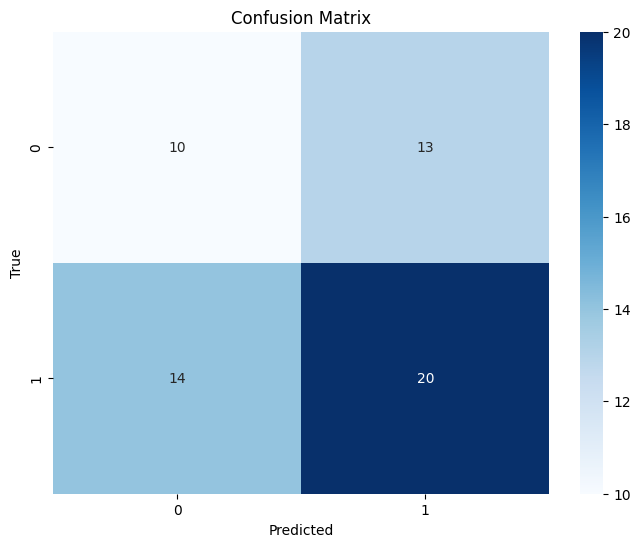

Random Forest
              precision    recall  f1-score   support

           0       0.53      0.78      0.63        23
           1       0.78      0.53      0.63        34

    accuracy                           0.63        57
   macro avg       0.66      0.66      0.63        57
weighted avg       0.68      0.63      0.63        57



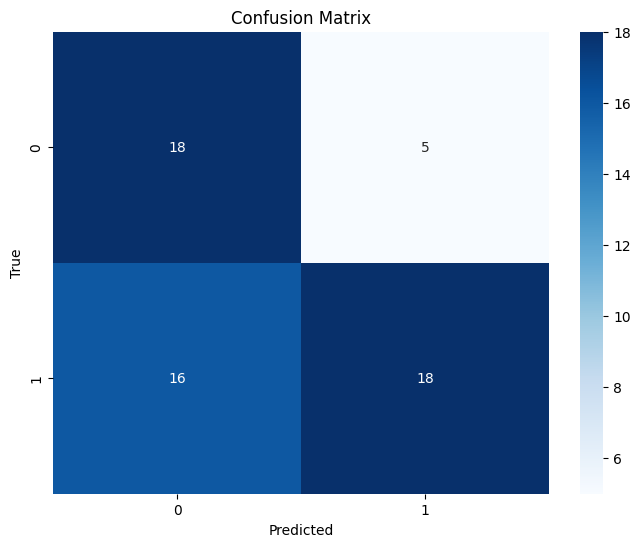

In [17]:
clean_data = clean_data(get_data(['t2w', 'adc']))

models = {
    'MLP' : MLPClassifier(),
    'Random Forest': RandomForestClassifier()
}

do_models(models, clean_data)